In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hlda_utils import *
from hlda_final import *

from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Toy corpus

In [2]:
# Define the vocabulary
vocabulary = [
    'apple', 'banana', 'cat', 'dog', 'eat',
    'fruit', 'go', 'happy', 'ice', 'juice'
]

# Create a toy corpus: list of documents, each document is a list of word strings
raw_corpus = [
    ['apple', 'banana', 'apple', 'juice'],
    ['cat', 'dog', 'cat', 'happy'],
    ['eat', 'fruit', 'banana', 'go'],
    ['dog', 'apple', 'happy', 'juice'],
    ['cat', 'eat', 'ice', 'banana']
]

In [3]:
# Create word to ID mapping
word2id = {word: idx for idx, word in enumerate(vocabulary)}
id2word = {idx: word for word, idx in word2id.items()}

# Convert raw corpus to word IDs
corpus = []
for doc in raw_corpus:
    doc_ids = [word2id[word] for word in doc]
    corpus.append(doc_ids)

print("Vocabulary Mapping:")
for word, idx in word2id.items():
    print(f"  {word}: {idx}")

print("\nCorpus (as word IDs):")
for i, doc in enumerate(corpus):
    print(f"  Document {i+1}: {doc}")

Vocabulary Mapping:
  apple: 0
  banana: 1
  cat: 2
  dog: 3
  eat: 4
  fruit: 5
  go: 6
  happy: 7
  ice: 8
  juice: 9

Corpus (as word IDs):
  Document 1: [0, 1, 0, 9]
  Document 2: [2, 3, 2, 7]
  Document 3: [4, 5, 1, 6]
  Document 4: [3, 0, 7, 9]
  Document 5: [2, 4, 8, 1]


In [4]:
# Parameters
L = 3  # Number of levels in the hierarchy
alpha = 1.0
gamma = 0.5
eta = 0.1
seed = 42
verbose = True

# Initialize the hLDA model
model = hLDA(
    corpus=corpus,
    vocabulary=vocabulary,
    L=L,
    alpha=alpha,
    gamma=gamma,
    eta=eta,
    seed=seed,
    verbose=verbose
)

In [5]:
# Run Gibbs sampling
iterations = 100
display_interval = 100
top_n = 3

collected_samples = model.gibbs_sampling(
    iterations=iterations,
    display_interval=display_interval,
    top_n=top_n
)

Starting hierarchical LDA sampling...
Iteration 100
Topic Node 0 (level=0, docs=5): cat(3), banana(3), eat(2)
    Topic Node 89 (level=1, docs=5): happy(2), dog(2), juice(1)
        Topic Node 94 (level=2, docs=2): apple(3), juice(0), ice(0)
        Topic Node 97 (level=2, docs=3): go(1), fruit(1), juice(0)
Total topic nodes created = 4


In [6]:
gamma_counts = model.gamma_eval()
print("\nGamma Evaluation (Number of topics per level):")
for lvl, count in enumerate(gamma_counts):
    print(f"  Level {lvl}: {count} topics")


Gamma Evaluation (Number of topics per level):
  Level 0: 1 topics
  Level 1: 1 topics
  Level 2: 2 topics


In [7]:
document_id = 0  # Document 1
alpha_fractions = model.alpha_eval(document_id)
print(f"\nAlpha Evaluation (Token distribution across levels) for Document {document_id+1}:")
for lvl, frac in enumerate(alpha_fractions):
    print(f"  Level {lvl}: {frac:.2f}")


Alpha Evaluation (Token distribution across levels) for Document 1:
  Level 0: 0.50
  Level 1: 0.00
  Level 2: 0.50


In [8]:
eta_coverage = model.eta_eval(n=3)
print("\nEta Evaluation (Top-2 word coverage per level):")
for lvl, coverage in enumerate(eta_coverage):
    print(f"  Level {lvl}: {coverage*100:.2f}%")


Eta Evaluation (Top-2 word coverage per level):
  Level 0: 80.00%
  Level 1: 100.00%
  Level 2: 100.00%


# Hyperparameter

In [9]:
###########################################
# LOAD & PREPROCESS 20 NEWSGROUPS
###########################################

dataset = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))
all_docs = dataset.data
all_labels = dataset.target

print("Total raw documents in 20newsgroups (train):", len(all_docs))

_, _, vocab, word2idx, idx2word, corpus_indices = \
    full_preprocessing_pipeline(all_docs, all_labels, 
                                min_word_length=2, 
                                min_freq=5)

print(f"Vocabulary size after min_freq=5: {len(vocab)}")

Total raw documents in 20newsgroups (train): 11314
Documents after filtering: 10999
Vocabulary size: 12942
Preprocessing complete.
Vocabulary size after min_freq=5: 12942


In [10]:
###########################################
# SELECT 500 SUITABLY-LONG DOCS
###########################################
# Pick the first 500 document with >= 100 tokens

selected_corpus = []
selected_count = 0
for doc in corpus_indices:
    if len(doc) >= 100:
        selected_corpus.append(doc)
        selected_count += 1
        if selected_count == 500:
            break

print(f"Number of selected documents: {len(selected_corpus)} (each >= 100 tokens).")

Number of selected documents: 500 (each >= 100 tokens).


In [11]:
###########################################
# Creating a table to store the results
###########################################
result_L3 = pd.DataFrame({
    'Model': pd.Series(dtype='str'), # model name
    'aim': pd.Series(dtype='str'), # what is the change of hyperparemeter. It can take one of 4 values:['base','alpha','gamma','eta']
    'alpha': pd.Series(dtype='float'),
    'gamma': pd.Series(dtype='float'),
    'eta': pd.Series(dtype='float'),
    'time':pd.Series(dtype='float'),
    'total_table': pd.Series(dtype='int'),
    'gamma_eval': pd.Series(dtype='object'), # a list of 3 integer indicating the number of tables at each level
    'eta_eval': pd.Series(dtype='object'), # a list of 3 floats indicating the fraction of top-n word distribution at each level
    'alpha_eval': pd.Series(dtype='object')  # a list of list. Each list contains 3 values. No of list depends on the number of document tested.
})


# For the following test, we will just apply alpha test on the followig documents
documents = [0,9,99,199,299]

In [12]:
def summarise(df, hlda_model, model_name, aim, documents, time):
    """
    Function to extract the required information and save it into the dataset
    """
    gamma_result = hlda_model.gamma_eval()
    eta_result = hlda_model.eta_eval()
    eta_result = [round(val, 2) for val in eta_result]
    alpha_results = []
    
    for doc_id in documents:
        alpha_eval = hlda_model.alpha_eval(doc_id)
        alpha_results.append([round(val, 2) for val in alpha_eval])
    
    data = {
        'Model': model_name,
        'aim' : aim,
        'alpha': hlda_model.alpha,
        'gamma': hlda_model.gamma,
        'eta': hlda_model.eta,
        'time': time,
        'total_table': NCRPNode.total_created_nodes,
        'gamma_eval': gamma_result,
        'eta_eval': eta_result,
        'alpha_eval': alpha_results
    }
    print(data)
    
    df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)
    
    return df

In [13]:
############################################
# BASE MODEL (alpha=10.0, gamma=1.0, eta=0.1)
############################################

base_model = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=1.0,
    eta=0.1,
    seed=42,
    verbose=False
)

# Run 1000 Gibbs iterations
time = base_model.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)

result_L3 = summarise(result_L3, base_model, "base_model",'base', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(3303), to(2754), is(1965), it(1787), you(1492)
    Topic Node 1 (level=1, docs=245): the(2253), of(1013), and(1013), in(665), to(571)
        Topic Node 2 (level=2, docs=7): good(46), excel(35), veri(30), miss(26), includ(22)
        Topic Node 3 (level=2, docs=188): the(1895), of(1230), to(644), and(605), that(597)
        Topic Node 7 (level=2, docs=9): of(139), and(90), health(60), tobacco(52), use(52)
        Topic Node 13 (level=2, docs=7): period(51), pp(42), play(31), power(29), pt(27)
        Topic Node 33 (level=2, docs=31): program(25), window(24), file(23), problem(21), use(18)
        Topic Node 1408 (level=2, docs=3): den(52), radiu(26), doubl(14), sqrt(11), starter(10)
    Topic Node 4 (level=1, docs=223): the(1307), of(495), and(408), to(346), in(269)
        Topic Node 5 (level=2, docs=77): the(383), is(349), of(294), that(226), to(123)
        Topic Node 6 (level=2, docs=118): th

In [14]:
# Gamma
gamma_counts = base_model.gamma_eval()
print("\nGamma Evaluation (Number of topics per level):")
for lvl, count in enumerate(gamma_counts):
    print(f"  Level {lvl}: {count} topics")

# Eta
eta_coverage = base_model.eta_eval(n = 5)
print("\nEta Evaluation (Top-5 word coverage per level):")
for lvl, coverage in enumerate(eta_coverage):
    print(f"  Level {lvl}: {coverage*100:.2f}%")


Gamma Evaluation (Number of topics per level):
  Level 0: 1 topics
  Level 1: 3 topics
  Level 2: 15 topics

Eta Evaluation (Top-5 word coverage per level):
  Level 0: 15.85%
  Level 1: 22.01%
  Level 2: 17.02%


In [15]:
# Alpha

for i in range(len(documents)):
    doc_id = documents[i]
    alpha_fractions = base_model.alpha_eval(doc_id)
    print(f"\nAlpha Evaluation (Token distribution across levels) for Document {doc_id+1}:")
    for lvl, frac in enumerate(alpha_fractions):
        print(f"  Level {lvl}: {frac:.2f}")

print(f"Takes {time} minutes to run.")


Alpha Evaluation (Token distribution across levels) for Document 1:
  Level 0: 0.77
  Level 1: 0.08
  Level 2: 0.15

Alpha Evaluation (Token distribution across levels) for Document 10:
  Level 0: 0.75
  Level 1: 0.05
  Level 2: 0.20

Alpha Evaluation (Token distribution across levels) for Document 100:
  Level 0: 0.66
  Level 1: 0.12
  Level 2: 0.22

Alpha Evaluation (Token distribution across levels) for Document 200:
  Level 0: 0.31
  Level 1: 0.67
  Level 2: 0.02

Alpha Evaluation (Token distribution across levels) for Document 300:
  Level 0: 0.23
  Level 1: 0.04
  Level 2: 0.72
Takes 45.48 minutes to run.


## Evaluating the effect of alpha
In general, if alpha value decreases, each document will be represented by less topics. Hence, we will expect the concentration at lower nodes to be higher. The converse is true. 

This means that the total number of topics to be created is less. **z** will now be smaller. Hence, we will expect the algorithm to converge faster. 

Therefore we will examine the effect of changing alpha in three ways:
1. Running time
2. number of nodes created(no of topics)
3. For a few selected topics, access the distributions of tokens into each levels(fraction of tokens in each level using alpha_fractions)

In [16]:
############################################
# ALPHA 1 (alpha=0.01)
############################################

model_alpha_1 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=0.01,   
    gamma=1.0,   # Same as base
    eta=0.1,     # Same as base
    seed=42,
    verbose=False
)


time = model_alpha_1.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)

result_L3 = summarise(result_L3, model_alpha_1, "model_alpha_1",'alpha', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(8682), to(4454), of(3951), and(3165), is(2734)
    Topic Node 1 (level=1, docs=181): billion(27), biolog(25), sequenc(24), constitut(21), insur(19)
        Topic Node 2 (level=2, docs=6): good(46), excel(35), veri(35), miss(26), uccxkvb(21)
        Topic Node 3 (level=2, docs=78): the(1119), of(689), and(489), in(294), to(231)
        Topic Node 7 (level=2, docs=9): of(126), and(70), health(65), tobacco(52), use(50)
        Topic Node 13 (level=2, docs=20): play(62), period(56), game(48), team(46), pp(44)
        Topic Node 26 (level=2, docs=23): program(27), run(20), window(19), server(17), motif(17)
        Topic Node 76 (level=2, docs=6): water(13), rock(6), plant(5), heat(4), kid(4)
        Topic Node 459 (level=2, docs=11): none(25), kill(17), arab(11), israel(9), land(7)
        Topic Node 3441 (level=2, docs=7): homosexu(10), men(7), promiscu(4), fetish(4), immor(4)
        Topic Node 3601

In [17]:
# Gamma
gamma_counts = model_alpha_1.gamma_eval()
print("\nGamma Evaluation (Number of topics per level):")
for lvl, count in enumerate(gamma_counts):
    print(f"  Level {lvl}: {count} topics")
    
# Alpha, test on 5 documents
documents = [0,9,99,199,299] 

for i in range(len(documents)):
    doc_id = documents[i]
    alpha_fractions = model_alpha_1.alpha_eval(doc_id)
    print(f"\nAlpha Evaluation (Token distribution across levels) for Document {doc_id+1}:")
    for lvl, frac in enumerate(alpha_fractions):
        print(f"  Level {lvl}: {frac:.2f}")


Gamma Evaluation (Number of topics per level):
  Level 0: 1 topics
  Level 1: 6 topics
  Level 2: 53 topics

Alpha Evaluation (Token distribution across levels) for Document 1:
  Level 0: 0.86
  Level 1: 0.00
  Level 2: 0.14

Alpha Evaluation (Token distribution across levels) for Document 10:
  Level 0: 0.83
  Level 1: 0.00
  Level 2: 0.17

Alpha Evaluation (Token distribution across levels) for Document 100:
  Level 0: 0.80
  Level 1: 0.00
  Level 2: 0.20

Alpha Evaluation (Token distribution across levels) for Document 200:
  Level 0: 0.57
  Level 1: 0.00
  Level 2: 0.43

Alpha Evaluation (Token distribution across levels) for Document 300:
  Level 0: 0.27
  Level 1: 0.00
  Level 2: 0.73


In [18]:
############################################
# ALPHA 2 (alpha=0.1)
############################################

model_alpha_2 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=0.1,  
    gamma=1.0,
    eta=0.1,
    seed=42,
    verbose=False
)

time = model_alpha_2.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_alpha_2, "model_alpha_2",'alpha', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(9077), to(4550), of(4160), and(3431), is(2679)
    Topic Node 1 (level=1, docs=134): palestinian(27), brian(15), reserv(15), professor(13), insur(11)
        Topic Node 2 (level=2, docs=5): good(47), excel(33), veri(31), miss(26), geoffrey(21)
        Topic Node 3 (level=2, docs=65): the(885), of(548), and(359), in(224), jesu(201)
        Topic Node 7 (level=2, docs=5): of(116), health(59), and(57), tobacco(52), use(43)
        Topic Node 13 (level=2, docs=7): period(51), pp(42), play(31), power(29), pt(27)
        Topic Node 24 (level=2, docs=30): game(76), team(68), he(59), play(41), season(37)
        Topic Node 87 (level=2, docs=6): dj(12), paid(8), speaker(7), soni(6), condit(6)
        Topic Node 124 (level=2, docs=5): circuit(14), input(12), decod(9), output(9), audio(8)
        Topic Node 594 (level=2, docs=4): washington(19), street(15), dc(14), york(13), new(13)
        Topic Node 2060 

In [19]:
# Gamma
gamma_counts = model_alpha_2.gamma_eval()
print("\nGamma Evaluation (Number of topics per level):")
for lvl, count in enumerate(gamma_counts):
    print(f"  Level {lvl}: {count} topics")
    
# Alpha, test on 5 documents
documents = [0,9,99,199,299] 

for i in range(len(documents)):
    doc_id = documents[i]
    alpha_fractions = model_alpha_2.alpha_eval(doc_id)
    print(f"\nAlpha Evaluation (Token distribution across levels) for Document {doc_id+1}:")
    for lvl, frac in enumerate(alpha_fractions):
        print(f"  Level {lvl}: {frac:.2f}")


Gamma Evaluation (Number of topics per level):
  Level 0: 1 topics
  Level 1: 4 topics
  Level 2: 43 topics

Alpha Evaluation (Token distribution across levels) for Document 1:
  Level 0: 0.87
  Level 1: 0.01
  Level 2: 0.13

Alpha Evaluation (Token distribution across levels) for Document 10:
  Level 0: 0.84
  Level 1: 0.00
  Level 2: 0.16

Alpha Evaluation (Token distribution across levels) for Document 100:
  Level 0: 0.76
  Level 1: 0.00
  Level 2: 0.24

Alpha Evaluation (Token distribution across levels) for Document 200:
  Level 0: 0.59
  Level 1: 0.41
  Level 2: 0.00

Alpha Evaluation (Token distribution across levels) for Document 300:
  Level 0: 0.27
  Level 1: 0.00
  Level 2: 0.73


In [20]:
############################################
# ALPHA 3 (alpha=1)
############################################

model_alpha_3 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=1,  
    gamma=1.0,
    eta=0.1,
    seed=42,
    verbose=False
)

time = model_alpha_3.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_alpha_3, "model_alpha_3",'alpha', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(9103), to(4603), of(4199), and(3083), is(2694)
    Topic Node 1 (level=1, docs=181): and(81), of(47), for(42), state(33), islam(28)
        Topic Node 2 (level=2, docs=7): good(46), excel(36), veri(34), miss(26), includ(22)
        Topic Node 3 (level=2, docs=72): the(914), of(531), and(466), in(277), jesu(200)
        Topic Node 7 (level=2, docs=7): of(95), and(67), health(65), use(52), tobacco(52)
        Topic Node 13 (level=2, docs=7): period(51), pp(42), play(31), power(29), pt(27)
        Topic Node 42 (level=2, docs=33): car(66), drive(26), speed(24), insur(23), year(19)
        Topic Node 49 (level=2, docs=8): splitfir(13), exhaust(11), air(11), intak(8), flow(8)
        Topic Node 66 (level=2, docs=33): chip(67), key(54), secur(46), clipper(41), encrypt(41)
        Topic Node 108 (level=2, docs=3): cabl(14), lock(13), kryptonit(11), steel(6), eyebal(5)
        Topic Node 200 (level=2, do

In [21]:
############################################
# ALPHA 4 (alpha=100)
############################################

model_alpha_4 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=100,  
    gamma=1.0,
    eta=0.1,
    seed=42,
    verbose=False
)

time = model_alpha_4.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_alpha_4, "model_alpha_4",'alpha', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(6004), of(3026), and(2765), to(2255), in(1882)
    Topic Node 1 (level=1, docs=291): that(1037), you(1004), it(774), is(548), do(540)
        Topic Node 2 (level=2, docs=9): good(47), excel(37), veri(29), miss(25), geoffrey(21)
        Topic Node 3 (level=2, docs=272): the(2950), of(1411), to(1204), and(908), in(750)
        Topic Node 7 (level=2, docs=2): health(58), of(58), tobacco(52), among(38), smokeless(37)
        Topic Node 13 (level=2, docs=8): period(53), pp(44), play(36), power(30), pt(27)
    Topic Node 4 (level=1, docs=191): to(614), it(444), you(392), have(337), that(312)
        Topic Node 5 (level=2, docs=113): is(453), the(327), that(258), of(196), be(139)
        Topic Node 6 (level=2, docs=48): the(810), and(582), they(422), wa(394), that(358)
        Topic Node 8 (level=2, docs=18): game(22), washington(19), disk(18), tower(17), borland(15)
        Topic Node 9 (level=2, docs=

In [22]:
############################################
# ALPHA 5 (alpha=1000)
############################################

model_alpha_5 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=1000,  
    gamma=1.0,
    eta=0.1,
    seed=42,
    verbose=False
)

time = model_alpha_5.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_alpha_5, "model_alpha_5",'alpha', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(7291), of(4081), and(2647), in(2589), for(1630)
    Topic Node 1 (level=1, docs=334): to(1637), you(1032), it(1016), that(944), have(787)
        Topic Node 2 (level=2, docs=11): good(43), excel(36), veri(28), miss(26), uccxkvb(21)
        Topic Node 3 (level=2, docs=303): the(2271), to(1502), and(976), that(823), of(721)
        Topic Node 7 (level=2, docs=10): vote(40), doug(26), ye(15), name(13), ballot(12)
        Topic Node 13 (level=2, docs=10): period(54), pp(44), play(36), power(28), pt(27)
    Topic Node 4 (level=1, docs=147): to(1397), the(769), it(680), that(667), on(448)
        Topic Node 5 (level=2, docs=97): is(470), that(176), be(139), not(126), to(117)
        Topic Node 6 (level=2, docs=23): they(402), wa(338), and(311), he(224), were(211)
        Topic Node 8 (level=2, docs=22): game(25), includ(17), disk(16), convert(16), borland(15)
        Topic Node 9 (level=2, docs=3): hea

## Evaluating the effect of gamma

This can simply be evaluated by the number of table created.

In [23]:
############################################
# GAMMA 1 (gamma=0.01)
############################################

model_gamma_1 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=10.0,  
    gamma=0.01,   
    eta=0.1,     
    seed=42,
    verbose=False
)

time = model_gamma_1.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_gamma_1, "model_gamma_1",'gamma', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(4220), and(2100), to(1837), in(1410), of(1387)
    Topic Node 1 (level=1, docs=500): the(2233), of(1319), and(1128), to(988), for(773)
        Topic Node 2 (level=2, docs=484): the(3933), is(2397), of(2200), to(2070), that(1668)
        Topic Node 3 (level=2, docs=5): period(51), pp(42), power(29), play(29), pt(23)
        Topic Node 25 (level=2, docs=6): pitcher(14), snf(11), mon(11), phi(11), atl(11)
        Topic Node 159 (level=2, docs=3): den(52), radiu(25), doubl(14), if(12), sqrt(11)
        Topic Node 1497 (level=2, docs=2): max(354), ql(62), giz(57), bhj(43), wm(30)
Total topic nodes created = 7
{'Model': 'model_gamma_1', 'aim': 'gamma', 'alpha': 10.0, 'gamma': 0.01, 'eta': 0.1, 'time': 33.74, 'total_table': 7, 'gamma_eval': [1, 1, 5], 'eta_eval': [np.float64(0.18), np.float64(0.14), np.float64(0.2)], 'alpha_eval': [[0.32, 0.35, 0.32], [0.18, 0.59, 0.23], [0.18, 0.4, 0.42], [0.1, 0.78, 0

In [25]:
# Gamma
gamma_counts = model_gamma_1.gamma_eval()
print("\nGamma Evaluation (Number of topics per level):")
for lvl, count in enumerate(gamma_counts):
    print(f"  Level {lvl}: {count} topics")


Gamma Evaluation (Number of topics per level):
  Level 0: 1 topics
  Level 1: 1 topics
  Level 2: 5 topics


In [26]:
############################################
# GAMMA 2 (gamma=0.1)
############################################

model_gamma_2 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=0.1,  
    eta=0.1,
    seed=42,
    verbose=False
)

time = model_gamma_2.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_gamma_2, "model_gamma_2",'gamma', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): to(2226), is(2125), the(2114), it(1603), that(1376)
    Topic Node 1 (level=1, docs=132): the(1851), of(1001), and(661), to(556), in(448)
        Topic Node 2 (level=2, docs=118): the(734), of(473), to(264), and(251), is(250)
        Topic Node 402 (level=2, docs=6): of(159), and(110), the(108), health(57), in(56)
        Topic Node 1531 (level=2, docs=6): warn(9), key(9), toolkit(8), virtualbind(8), string(8)
        Topic Node 1710 (level=2, docs=2): max(354), ql(62), giz(57), bhj(43), wm(30)
    Topic Node 3 (level=1, docs=368): the(3531), of(1872), and(1348), in(995), to(948)
        Topic Node 4 (level=2, docs=324): the(2048), and(1245), to(901), they(810), that(784)
        Topic Node 5 (level=2, docs=5): period(51), pp(42), power(29), play(29), pt(23)
        Topic Node 6 (level=2, docs=8): for(39), biolog(24), sequenc(24), launch(23), orbit(22)
        Topic Node 66 (level=2, docs=11): good(4

In [27]:
############################################
# GAMMA 2 (gamma=10)
############################################

model_gamma_3 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=10,  
    eta=0.1,
    seed=42,
    verbose=False
)

time = model_gamma_3.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_gamma_3, "model_gamma_3",'gamma', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(6169), of(3267), to(2906), and(2336), in(1952)
    Topic Node 3 (level=1, docs=22): data(19), remot(11), imag(11), user(9), applic(9)
        Topic Node 36 (level=2, docs=5): mission(45), orbit(44), space(42), shuttl(38), astronaut(36)
        Topic Node 42 (level=2, docs=5): health(59), of(56), tobacco(52), use(43), among(38)
        Topic Node 160 (level=2, docs=3): pitcher(14), cub(11), mon(11), atl(11), snf(11)
        Topic Node 276 (level=2, docs=4): vote(46), window(32), ye(15), nt(15), unmoder(13)
        Topic Node 1629 (level=2, docs=5): washington(19), street(16), abc(15), york(14), dc(14)
    Topic Node 9 (level=1, docs=335): the(1888), and(1180), that(904), to(867), they(765)
        Topic Node 156 (level=2, docs=298): the(481), it(452), you(428), to(393), is(393)
        Topic Node 165 (level=2, docs=33): the(393), of(250), and(164), armenian(151), in(101)
        Topic Node 329 (le

In [28]:
############################################
# GAMMA 4 (gamma=100)
############################################

model_gamma_4 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=100,  
    eta=0.1,
    seed=42,
    verbose=False
)

time = model_gamma_4.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_gamma_4, "model_gamma_4",'gamma', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(3150), to(2030), is(1358), it(1203), of(1080)
    Topic Node 35 (level=1, docs=49): of(244), the(199), and(183), in(76), wa(74)
        Topic Node 294 (level=2, docs=49): the(369), and(265), of(226), in(150), to(137)
    Topic Node 204 (level=1, docs=6): njd(14), pgh(11), rough(11), lead(10), shot(9)
        Topic Node 496 (level=2, docs=6): period(51), pp(42), power(29), play(29), pt(27)
    Topic Node 209 (level=1, docs=15): report(8), corn(7), brake(6), she(5), pain(5)
        Topic Node 642 (level=2, docs=15): wa(44), year(25), had(22), insur(20), rate(13)
    Topic Node 275 (level=1, docs=2): mv(13), mu(12), mt(9), mp(9), mi(8)
        Topic Node 276 (level=2, docs=2): max(354), ql(62), giz(57), bhj(43), wm(30)
    Topic Node 478 (level=1, docs=428): the(2796), and(1683), to(1289), that(1131), wa(997)
        Topic Node 479 (level=2, docs=384): the(3872), of(2423), to(1434), is(1424), and(12

## Evaluating the effect of Eta

In [29]:
############################################
# ETA 1 (eta=0.01)
############################################

model_eta_1 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=1.0,
    eta=0.01,  
    seed=42,
    verbose=False
)

time = model_eta_1.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_eta_1, "model_eta_1",'eta', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(2571), to(1792), and(1364), for(1150), in(924)
    Topic Node 1 (level=1, docs=304): the(1630), is(1530), that(1431), of(1240), to(1097)
        Topic Node 3 (level=2, docs=247): the(2918), of(1320), and(1011), in(769), to(680)
        Topic Node 7 (level=2, docs=8): the(79), and(50), of(46), orbit(25), in(19)
        Topic Node 13 (level=2, docs=4): period(42), pp(37), play(31), power(29), pt(27)
        Topic Node 25 (level=2, docs=8): none(25), kill(18), in(13), by(12), secur(7)
        Topic Node 112 (level=2, docs=21): the(66), to(31), window(23), can(20), program(15)
        Topic Node 216 (level=2, docs=13): for(31), borland(15), guid(14), includ(14), disk(13)
        Topic Node 2236 (level=2, docs=2): den(52), radiu(25), sin(15), doubl(14), sqrt(11)
        Topic Node 3467 (level=2, docs=1): mv(12), mu(12), mh(9), mt(9), mp(9)
    Topic Node 4 (level=1, docs=105): the(1033), of(437), is(4

In [30]:
############################################
# ETA 2 (eta=10.0)
############################################

model_eta_2 = hLDA(
    corpus=selected_corpus,
    vocabulary=vocab,
    L=3,
    alpha=10.0,
    gamma=1.0,
    eta=10.0,  
    seed=42,
    verbose=False
)

time = model_eta_2.gibbs_sampling(
    iterations=1000,
    display_interval=1000,
    top_n=5
)
result_L3 = summarise(result_L3, model_eta_2, "model_eta_2",'eta', documents, time)

Starting hierarchical LDA sampling...
Iteration 1000
Topic Node 0 (level=0, docs=500): the(10382), of(4902), to(4894), and(4290), in(2924)
    Topic Node 1 (level=1, docs=279): period(47), pp(42), power(30), play(30), scorer(23)
        Topic Node 80 (level=2, docs=2): valid(1), dealt(1), cure(1), hope(1), quick(1)
        Topic Node 175 (level=2, docs=12): wrong(2), add(2), lifestyl(2), arrow(1), griffin(1)
        Topic Node 176 (level=2, docs=4): port(1), choic(1), expertis(1), quick(1), michael(1)
        Topic Node 307 (level=2, docs=16): observ(2), catalog(2), vertic(1), conduct(1), agent(1)
        Topic Node 315 (level=2, docs=9): first(2), score(2), ottawa(2), pt(2), period(2)
        Topic Node 325 (level=2, docs=9): det(4), van(3), canuck(3), red(3), linden(2)
        Topic Node 333 (level=2, docs=8): stl(4), phi(2), thompson(2), laker(1), upset(1)
        Topic Node 350 (level=2, docs=12): draw(2), professor(2), mydisplay(2), ruff(1), synchron(1)
        Topic Node 352 (lev

# Visualisations

In [90]:
# Create a new column to combine hyperparameter name and value for x-axis
result_L3['param_setting'] = result_L3.apply(
    lambda row: f"{row['aim']}={row[row['aim']]}" if row['aim'] != 'base' else 'base',
    axis=1
)

# Extending gamma info
level_info = pd.DataFrame(result_L3['gamma_eval'].tolist(), columns = ["1", "2", "3"]) # extending gamma_eval

# Extending result_L3
result_L3_extended = pd.concat([result_L3, level_info], axis = 1)
result_L3_extended = pd.melt(result_L3_extended, id_vars = ['Model', 'aim', 'alpha', 'gamma', 'eta', 'time', 'total_table',
       'gamma_eval', 'eta_eval', 'alpha_eval', 'param_setting'], 
                             value_vars=["1", "2", "3"],  
                             var_name='Level',     
                             value_name='Topics' )

## 1. Time vs Model

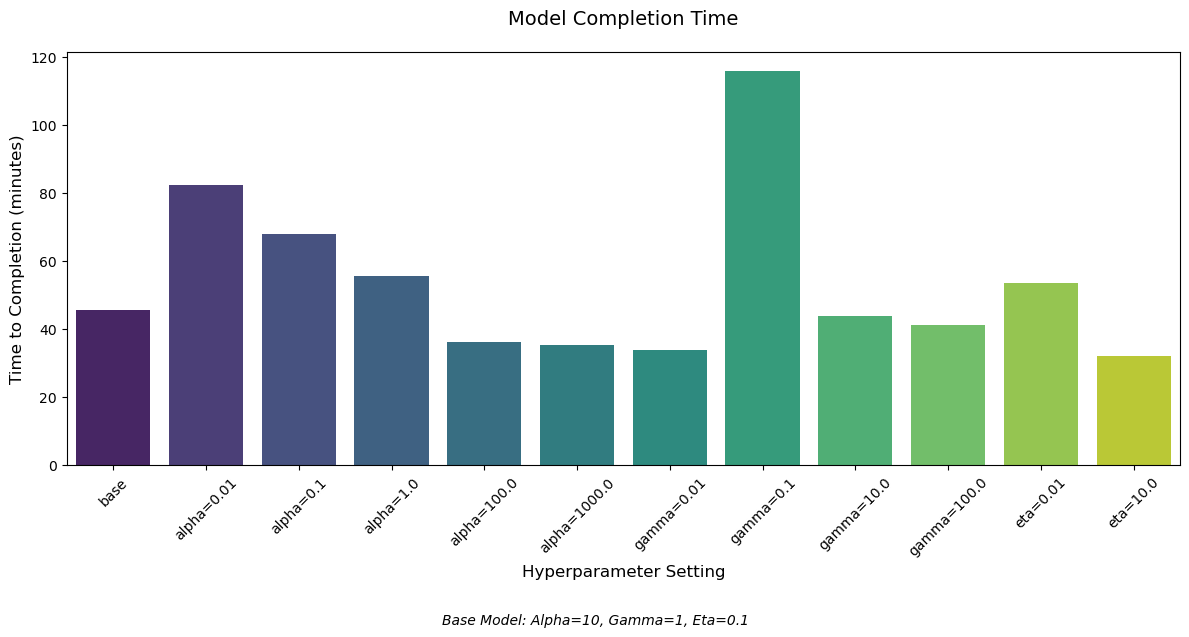

In [96]:
base_model_params = "Base Model: Alpha=10, Gamma=1, Eta=0.1"

plt.figure(figsize=(12, 6))
sns.barplot(data=result_L3, x='param_setting', y='time', hue='param_setting', palette='viridis', legend=False)

plt.title('Model Completion Time', fontsize=14, pad=20)
plt.xlabel('Hyperparameter Setting', fontsize=12)
plt.ylabel('Time to Completion (minutes)', fontsize=12)
plt.xticks(rotation=45)
plt.figtext(0.5, -0.05, base_model_params, wrap=True, horizontalalignment='center', fontsize=10, style='italic')
plt.tight_layout()

plt.show()

General trend:
1. time increases as $\alpha$ decreases.
2. time increases as $\eta$ increases.

$\gamma$ = 0.1 appears to be an anomaly because it takes more time than models with $\gamma$ values higher and lower than it. Tried to run it a few times, it all took unusual amount of time to complete.

## 2. Total topic created vs Model

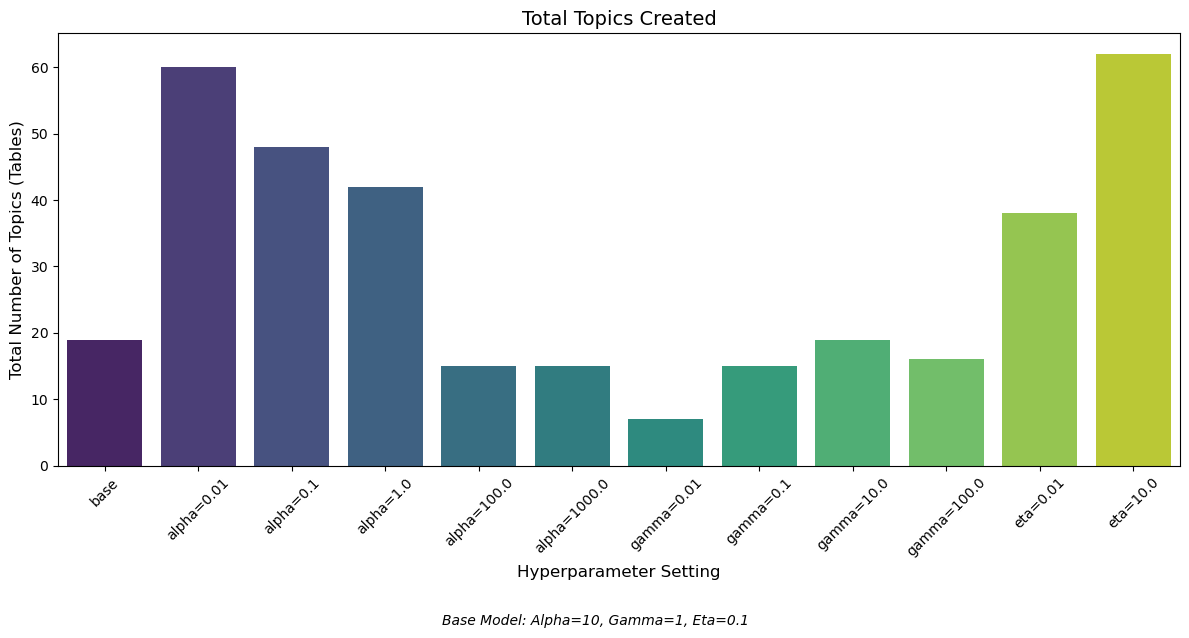

In [95]:
plt.figure(figsize=(12, 6))
sns.barplot(data=result_L3, x='param_setting', y='total_table', hue='param_setting', palette='viridis', legend = False)

plt.title('Total Topics Created', fontsize=14)
plt.xlabel('Hyperparameter Setting', fontsize=12)
plt.ylabel('Total Number of Topics (Tables)', fontsize=12)
plt.xticks(rotation=45)
plt.figtext(0.5, -0.05, base_model_params, wrap=True, horizontalalignment='center', fontsize=10, style='italic')
plt.tight_layout()

plt.show()

Influence of $\gamma$ on the total number of table created is less than $\alpha$ and $\beta$.

Higher $\alpha$ value means that the document will be represented more uniformly by more topics and a lower $\alpha$ value means that the document will be explained by a fewer one. From the result, we can observe that the model with lower alpha value actually requires more table in total to explain the data. 



In [100]:
alpha_data = result_L3_extended.loc[result_L3_extended['aim'].isin(['alpha', 'base'])]
alpha_data = alpha_data.sort_values(by = ['alpha','Level'], ascending = [True, True])

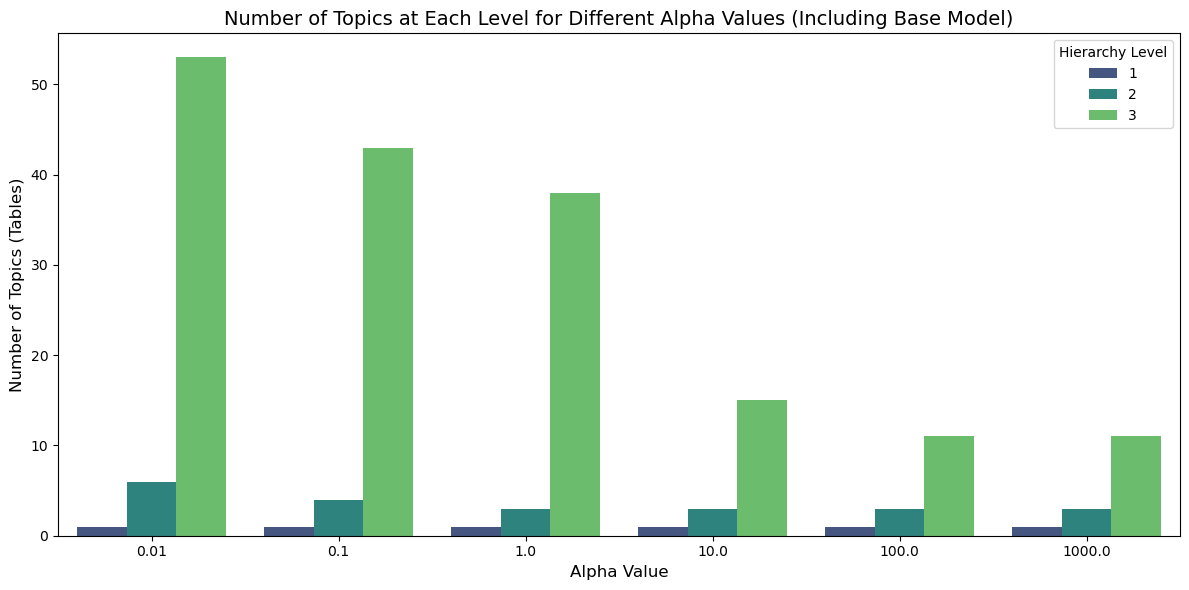

In [101]:
plt.figure(figsize=(12, 6))
sns.barplot(data=alpha_data, x='alpha', y='Topics', hue='Level', palette='viridis')

plt.title('Number of Topics at Each Level for Different Alpha Values (Including Base Model)', fontsize=14)
plt.xlabel('Alpha Value', fontsize=12)
plt.ylabel('Number of Topics (Tables)', fontsize=12)
plt.legend(title='Hierarchy Level')
plt.tight_layout()

plt.show()

Need to examine the number of words in each topic...

## Top-5 word Proportion

In [119]:
# Filter for base, eta, and alpha models
eta_alpha_models = result_L3[result_L3['aim'].isin(['base', 'eta', 'alpha'])].copy()
eta_alpha_models.reset_index(drop=True, inplace=True)

# Expand eta_eval into separate columns for each level
eta_eval_expanded = pd.DataFrame(eta_alpha_models['eta_eval'].tolist(), columns=['Level 1', 'Level 2', 'Level 3'])


# Combine with model labels
heatmap_data = pd.concat([eta_alpha_models[['param_setting']], eta_eval_expanded], axis=1)

# Melt the dataframe for heatmap plotting
heatmap_melted = heatmap_data.melt(id_vars='param_setting', var_name='Level', value_name='Top-5 Word Proportion')

# Pivot for heatmap format
heatmap_pivot = heatmap_melted.pivot(index='Level', columns='param_setting', values='Top-5 Word Proportion')


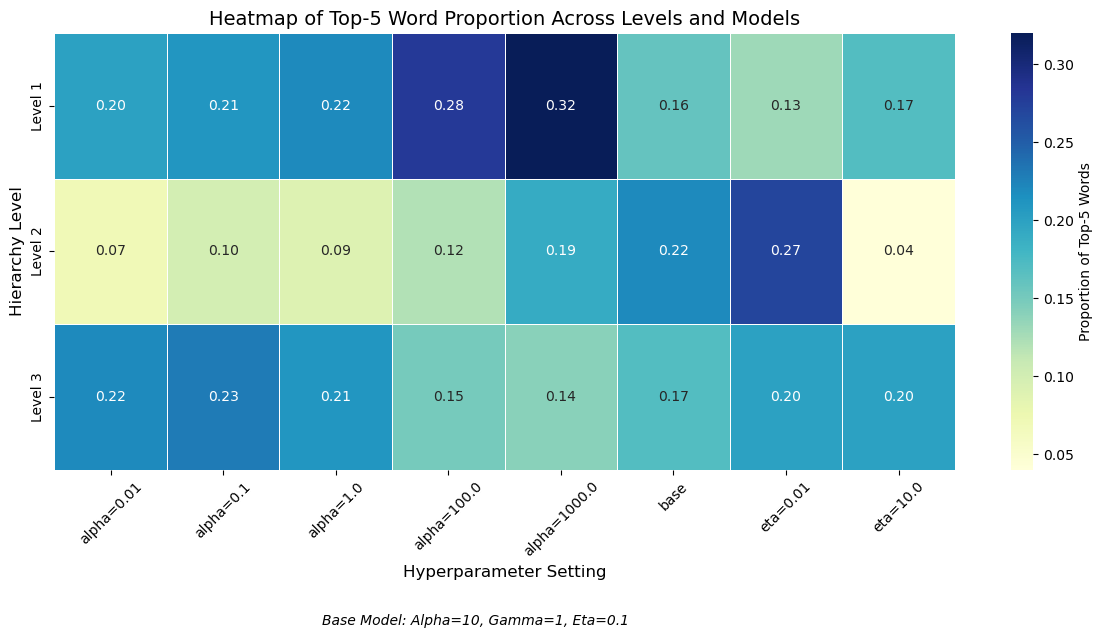

In [131]:
# Plotting the Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Proportion of Top-5 Words'})

plt.title('Heatmap of Top-5 Word Proportion Across Levels and Models', fontsize=14)
plt.xlabel('Hyperparameter Setting', fontsize=12)
plt.ylabel('Hierarchy Level', fontsize=12)
plt.xticks(rotation=45)
plt.figtext(0.4, -0.05, base_model_params, wrap=True, horizontalalignment='center', fontsize=10, style='italic')
plt.tight_layout()

plt.show()

In [145]:
alpha_models = result_L3[result_L3['aim'].isin(['base', 'alpha'])].copy()
alpha_models.reset_index(drop=True, inplace=True)

# Expand alpha_eval (list of lists)
alpha_eval_expanded = pd.DataFrame(alpha_models['alpha_eval'].tolist())

# Map indices 0,1,2,3,4 to actual documents [0,9,99,199,299]
document_mapping = {0: 0, 1: 9, 2: 99, 3: 199, 4: 299}
alpha_eval_expanded.rename(columns=document_mapping, inplace=True)

# Combine with alpha values
heatmap_data2 = pd.concat([alpha_models[['alpha']], alpha_eval_expanded], axis=1)

# Sort based on alpha value
heatmap_data2 = heatmap_data2.sort_values(by='alpha')

In [146]:
# Melt the dataframe for faceted heatmap
melted_data = heatmap_data2.melt(id_vars='alpha', var_name='Document', value_name='Topic Proportion')

# Expand each document's topic proportions into separate levels (Level 1, 2, 3)
expanded_docs = melted_data.dropna().apply(
    lambda row: pd.Series(row['Topic Proportion'], index=['Level 1', 'Level 2', 'Level 3']), axis=1
)
expanded_docs = pd.concat([melted_data[['alpha', 'Document']], expanded_docs], axis=1)

# Final melt for heatmap plotting
final_melt = expanded_docs.melt(id_vars=['alpha', 'Document'], var_name='Level', value_name='Proportion')

# Ensure proper numeric sorting for alpha
final_melt['alpha'] = pd.to_numeric(final_melt['alpha'], errors='coerce')

# Pivot data for heatmap plotting in each facet
pivot_data = {
    doc: df.pivot(index='Level', columns='alpha', values='Proportion')
    for doc, df in final_melt.groupby('Document')
}

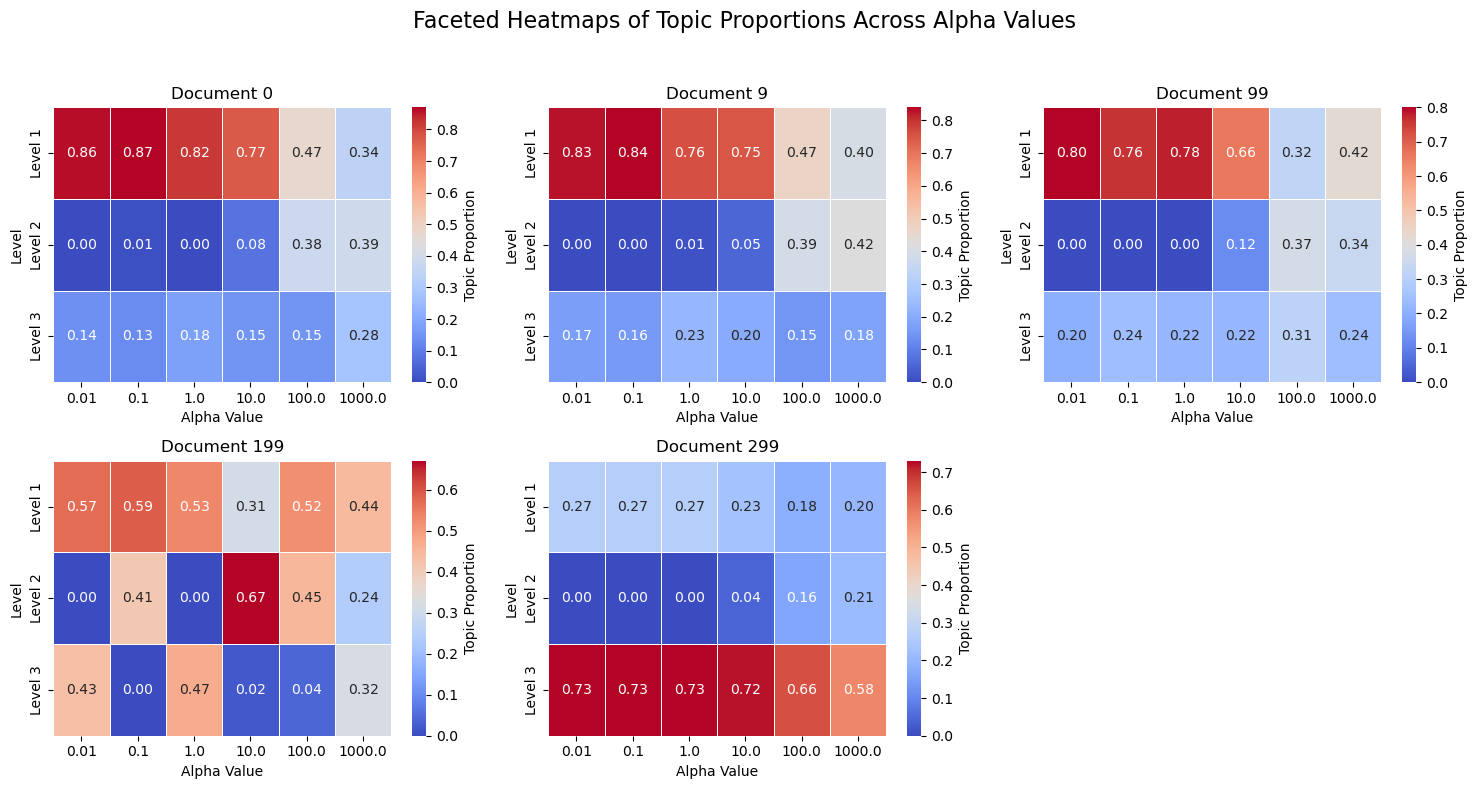

In [147]:
# Plotting faceted heatmaps manually
num_docs = len(pivot_data)
cols = 3
rows = (num_docs // cols) + int(num_docs % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot heatmaps
for ax, (doc, data) in zip(axes, pivot_data.items()):
    sns.heatmap(
        data,
        ax=ax,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={'label': 'Topic Proportion'}
    )
    ax.set_title(f'Document {doc}')
    ax.set_xlabel('Alpha Value')
    ax.set_ylabel('Level')

# Remove empty subplots
for i in range(num_docs, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Faceted Heatmaps of Topic Proportions Across Alpha Values', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Observations:
Alpha is working correctly as the document are represented more evenly as alpha increases.